In [121]:
import os
import pandas as pd
import numpy as np


In [122]:
# Ler arquivos do diretorio de dados historicos
dir = '../data/brazil/'
ext = '.csv'

history = pd.DataFrame()
columns = ['Res', 'AvgH', 'AvgD', 'AvgA']

# Iterar por todos os arquivos do diretorio
for dirpath, dirnames, files in os.walk(dir):
    for file in files:
        if file.endswith(ext):
            # Abrir arquivo e adicionar ao DataFrame
            contents = pd.read_csv(os.path.join(dirpath, file))
            history = pd.concat([history, contents[columns]])

# Imprimir 5 primeiras linhas
history.head()

,Res,AvgH,AvgD,AvgA
0,D,1.69,3.50,4.90
1,D,2.59,3.23,2.58
2,H,1.59,3.67,5.64
3,H,2.35,3.26,2.84
4,A,1.89,3.33,3.89


In [123]:
# Agora, vamos analisar a taxa de acertos das faixas de odds
# Vamos criar um dataframe com essas faixas e inserir a quantidade de acertos
# Res será utilizado para dizer qual foi o resultado do jogo: H, D ou A
# AvgH, AvgD e AvgA serão utilizados para dizer qual foi a odd média do jogo

decimalPlaces = 2
minOdd = 1
maxOdd = 10
minGames = 10
rangeQty = (maxOdd-minOdd)*(10**decimalPlaces)

# Criando as faixas de odds:
ranges = np.linspace(minOdd, maxOdd, rangeQty).round(decimalPlaces)

# Colunas do dataframe que será criado:
# % Odd: 1 / odd - percentual de acerto que a odd teria que ter para ser lucrativa
# % Real: (quantidade de acertos) / (quantidade de jogos) - percentual de acerto real
# AvgHT: quantidade de jogos com odd média de vitória do time da casa igual a faixa
# AvgHR: quantidade de acertos com odd média de vitória do time da casa igual a faixa
# AvgDT: quantidade de jogos com odd média de empate igual a faixa
# AvgDR: quantidade de acertos com odd média de empate igual a faixa
# AvgAT: quantidade de jogos com odd média de vitória do time visitante igual a faixa
# AvgAR: quantidade de acertos com odd média de vitória do time visitante igual a faixa
analysisColumns = ['% Odd', '% Real', 'Result', 'Total', 'AvgHT',
                   'AvgHR', 'AvgDT', 'AvgDR', 'AvgAT', 'AvgAR']

# Criando o dataframe:
data = pd.DataFrame(0, index=ranges, columns=analysisColumns)

# Extraindo as odds de cada resultado:
ResHseries = history['AvgH'][history['Res'] == 'H']
ResDseries = history['AvgD'][history['Res'] == 'D']
ResAseries = history['AvgA'][history['Res'] == 'A']

# Preenchendo o dataframe com as informações:
for i in ranges:
    data.at[i, 'AvgHT'] = (history['AvgH'] == i).sum()
    data.at[i, 'AvgHR'] = (ResHseries == i).sum()

    data.at[i, 'AvgDT'] = (history['AvgD'] == i).sum()
    data.at[i, 'AvgDR'] = (ResDseries == i).sum()

    data.at[i, 'AvgAT'] = (history['AvgA'] == i).sum()
    data.at[i, 'AvgAR'] = (ResAseries == i).sum()

    data.at[i, '% Odd'] = (1/i).round(2)

    data.at[i, 'Result'] = data.at[i, 'AvgHR'] + \
        data.at[i, 'AvgDR'] + data.at[i, 'AvgAR']
    data.at[i, 'Total'] = data.at[i, 'AvgHT'] + \
        data.at[i, 'AvgDT'] + data.at[i, 'AvgAT']

    if (data.at[i, 'Total'] > minGames):
        data.at[i, '% Real'] = (data.at[i, 'Result'] /
                                data.at[i, 'Total']).round(2)
    else:
        data.at[i, '% Real'] = 0


In [124]:

# Visualizando as linhas em que a taxa de acerto é maior que a taxa de odd, ordenadas decrescentemente pela quantidade total de jogos
# Imprimir apenas o indice e as colunas % Odd, % Real e Total
data[data['% Real'] > data['% Odd']].sort_values(by='Total', ascending=False)[
    ['% Odd', '% Real', 'Total']].head(10)

,% Odd,% Real,Total
3.18,0.31,0.33,85
3.19,0.31,0.34,83
3.30,0.30,0.33,73
3.13,0.32,0.38,73
3.38,0.30,0.34,71
3.07,0.33,0.38,69
3.31,0.30,0.31,64
2.99,0.33,0.38,63
3.00,0.33,0.36,58
2.94,0.34,0.40,52


In [125]:
# Iterando pelas faixas, podemos analisar qual o melhor intervalo de faixas para apostar, através de um algoritmo guloso
begin = ranges[0]
end = ranges[-1]
sum = 0
bestRanges = pd.DataFrame(columns=['Begin', 'End', 'Sum'])

for i in ranges:
    diff = data.at[i, '% Real'] - data.at[i, '% Odd']
    if (diff >= 0):
        sum += diff
        end = i
    else:
        if (sum > 0):
            bestRanges.loc[len(bestRanges)] = [begin, end, sum]
        begin = i
        end = i
        sum = 0

# Visualizando os melhores intervalos de faixas para apostar, ordenados decrescentemente pela soma
bestRanges.sort_values(by='Sum', ascending=False).head(10)

,Begin,End,Sum
44,2.87,2.94,0.52
19,1.91,1.94,0.39
83,4.82,4.84,0.36
24,2.10,2.12,0.28
23,2.07,2.09,0.27
29,2.27,2.30,0.24
76,4.45,4.46,0.23
62,3.79,3.81,0.22
38,2.66,2.68,0.20
42,2.79,2.81,0.19


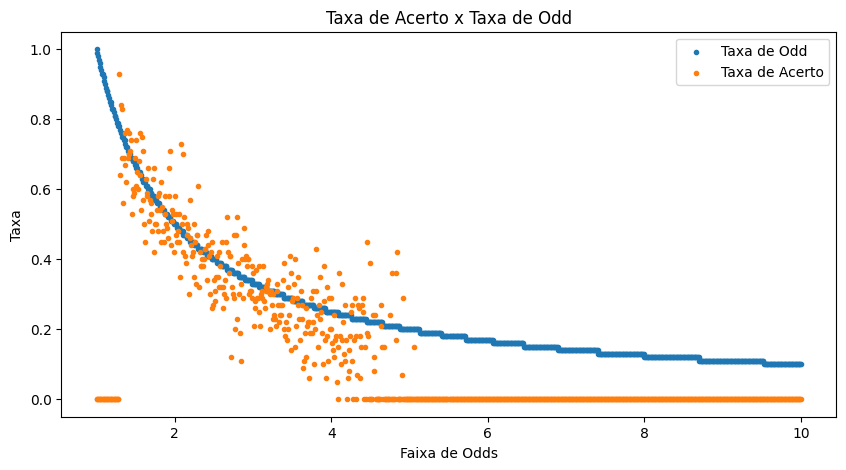

In [138]:
# Agora vamos realizar um plot scatter para visualizar melhor os dados
# Importando as bibliotecas necessárias
import matplotlib.pyplot as plt

# Plotando o gráfico
plt.figure(figsize=(10, 5))
plt.scatter(data.index, data['% Odd'], label='Taxa de Odd', marker='.')
plt.scatter(data.index, data['% Real'], label='Taxa de Acerto', marker='.')
plt.xlabel('Faixa de Odds')
plt.ylabel('Taxa')
plt.title('Taxa de Acerto x Taxa de Odd')
plt.legend()
plt.show()
